# Analysing Face Detection on African data

### Importing Libraries

In [61]:
import gc
import os
import sys
import math
import glob
import tqdm
import random
import numpy as np
from tqdm import tqdm
from time import sleep

In [42]:
import pandas as pd
import xml.etree.ElementTree as ET

In [10]:
import cv2
import dlib
from imutils import face_utils
from skimage.feature import hog
from skimage import data,exposure

In [8]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

In [163]:
from ipywidgets import widgets, interactive

### Defining Paths

#### Path to Data Folder

In [15]:
path_folder_bagamoyo_data = '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/'

#### Path to Frames

In [16]:
path_folder_all_frames = path_folder_bagamoyo_data + '/bagamoyo_frames_all_in_one/'

In [17]:
path_folder_wise_frames = path_folder_bagamoyo_data + '/bagamoyo_frames_folder_wise/'

#### Path to xml files

In [25]:
!ls

data-analysis.ipynb  train_dlib_detector.py  ZFace label analysis.ipynb
README.md	     training.xml


comment: will change

In [28]:
path_xml_file = 'training.xml'

## Things to be calculated

1. Absolute - Find the number of frames in total in which face is detected, and how many in each frame
2. Check continuity - a visualisation for seeing which frames in the continuity.
3. This can be done by writing a single script which does these things if an xml file is generated with the name of the image and the coordinates of the bounding boxes in it.

### Let's take an example of training.xml and try to get some visualisations. 

1. Once the relevant visualisations can be obtained, then just generate an XML from every face detector's output and run the same script.
2. Then you must be able to take these different plots and plot them in one.
3. Or when plotting one, you should be able to take multiple XML and plot them on a single axis.

#### Reading xml file

In [87]:
"VIDEO_06-female-confusion_20180516_091808_1375649000 046.jpg".rsplit(' ',1)

['VIDEO_06-female-confusion_20180516_091808_1375649000', '046.jpg']

In [88]:
def getDataframeFromXML(path_file_xml):
    """
    Returns the dataframe(columns- videoName,frameNo,faceNo,left,right,width,height) from given xml file path holding bounding boxes for each frame.
    
    Parameters
    ----------
    path_file_xml : path of the XML file.
    
    Returns
    -------
    Pandas dataframe
        Information about images and their boxes.
    """
    
    #make a new dataframe to store the data.
    df = pd.DataFrame(columns=['name_image','name_video','num_frame','num_box','left','top','width','height'])
    
    #parsing XML and populating dataframe
    tree = ET.parse(path_file_xml)
    root = tree.getroot()
    for image in tqdm(root.iter('image')):
        name_file = image.attrib['file']
        name_video = name_file.split('.')[0].rsplit(' ',1)[0]
        num_frame = (int)(name_file.split('.')[0].rsplit(' ',1)[1])
        
        #if no box, box attributes are np.nan
        if (len(image) == 0):
            row_data = [name_file, name_video, num_frame, np.nan, np.nan, np.nan, np.nan, np.nan]
            df.loc[len(df)] = row_data
        else:
            for box_num,box in enumerate(image):
                box_attribs = box.attrib
                row_data = [name_file, name_video, num_frame, box_num+1, box_attribs['left'], box_attribs['top'],box_attribs['width'],box_attribs['height']]
                df.loc[len(df)] = row_data
    return df
    

In [89]:
df_zface = getDataframeFromXML(path_xml_file)

44492it [06:46, 109.35it/s]


In [93]:
df_zface

,name_image,name_video,num_frame,num_box,left,top,width,height
0,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,1,1,1044,987,412,447
1,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,2,NaN,NaN,NaN,NaN,NaN
2,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,3,NaN,NaN,NaN,NaN,NaN
3,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,4,NaN,NaN,NaN,NaN,NaN
4,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,5,NaN,NaN,NaN,NaN,NaN
5,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,6,NaN,NaN,NaN,NaN,NaN
6,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,7,NaN,NaN,NaN,NaN,NaN
7,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,8,NaN,NaN,NaN,NaN,NaN
8,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,9,NaN,NaN,NaN,NaN,NaN
9,VIDEO_00-male-surprise_20180516_091529_2193933...,VIDEO_00-male-surprise_20180516_091529_219393302,10,NaN,NaN,NaN,NaN,NaN


In [92]:
set(df_zfacedcsds['name_video'])  

{'VIDEO_00-male-surprise_20180516_091529_219393302',
 'VIDEO_00-male-surprise_20180516_091541_1754978908',
 'VIDEO_00-male-surprise_20180516_091551_1272027070',
 'VIDEO_00-male-surprise_20180516_091601_315735604',
 'VIDEO_00-male-surprise_20180516_091612_1350564397',
 'VIDEO_00-male-surprise_20180516_091622_222850491',
 'VIDEO_00-male-surprise_20180516_091859_1464474503',
 'VIDEO_00-male-surprise_20180516_091908_1711675951',
 'VIDEO_00-male-surprise_20180516_103058_1712496391',
 'VIDEO_00-male-surprise_20180516_103111_732090686',
 'VIDEO_00-male-surprise_20180516_103333_484753936',
 'VIDEO_00-male-surprise_20180516_103627_470608290',
 'VIDEO_00-male-surprise_20180516_103859_1577732647',
 'VIDEO_00-male-surprise_20180516_104130_28129801',
 'VIDEO_00-male-surprise_20180516_104436_2035574348',
 'VIDEO_00-male-surprise_20180516_104931_1469741845',
 'VIDEO_00-male-surprise_20180516_105241_358096433',
 'VIDEO_00-male-surprise_20180516_105557_1402434414',
 'VIDEO_00-male-surprise_20180516_105

In [120]:
def getDictVideoBoxesPerFrame(path_file_xml):
    """
    Returns a dictionary of form {video_name:[(frame_no,no_of_boxes),(frame_no+1,no_of_boxes),(frame_no+2,no_of_boxes)]} given the path of xml file
    """
    
    result = {}
    #parsing XML and generating dictionary
    tree = ET.parse(path_file_xml)
    root = tree.getroot()
    for image in tqdm(root.iter('image')):
        name_file = image.attrib['file']
        name_video = name_file.split('.')[0].rsplit(' ',1)[0]
        num_frame = (int)(name_file.split('.')[0].rsplit(' ',1)[1])
        num_boxes = len(image)
        if name_video in result:
            result[name_video].append((num_frame, num_boxes))
        else:
            result[name_video] = [(num_frame, num_boxes)]    
    return result

In [121]:
dictVideoBoxesPerFrame = getDictVideoBoxesPerFrame('training.xml')







0it [00:00, ?it/s]





39692it [00:00, 392143.75it/s]





44492it [00:00, 379206.80it/s]

### Plotting number of boxes detected vs frame number 

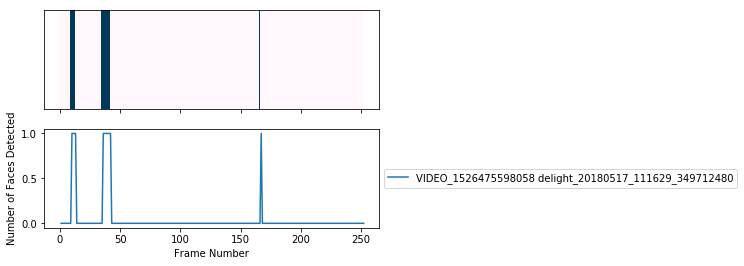

In [165]:
def plotBoxesInFrames(videoName,zippedListFrameBox):
    """
    Plots the number of boxes with frame given the name of the video and corresponding zippedlist of form [(frame_no,no_of_boxes),(frame_no+1,no_of_boxes)...]
    """
    
    unzippedList = zip(*zippedListFrameBox)
    x = np.array(unzippedList[0])
    y = np.array(unzippedList[1])
    
    max_faces = max(y)
    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

#     extent = [0, x[-1],0,max_faces]
    ax.imshow(y[np.newaxis,:], cmap="PuBu", aspect="auto")
    ax.set_yticks([])
#     ax.set_xlim(extent[0], extent[1])

    ax2.plot(x,y)
    ax2.legend([videoName],loc='center left',bbox_to_anchor=(1, 0.5))
#     ax2.set_xlim(extent[0], extent[1])
    plt.xlabel("Frame Number")
    plt.ylabel("Number of Faces Detected")
#     plt.tight_layout()
    plt.show()
    
plotBoxesInFrames(k,v)

In [202]:
l=dictVideoBoxesPerFrame.keys()


In [204]:
video_file_name = widgets.Dropdown(options=l,description='Video File:')

In [205]:
def plotit(video_file_name):
    plotBoxesInFrames(video_file_name,dictVideoBoxesPerFrame[video_file_name])

In [206]:
interactive(plotit,video_file_name=video_file_name)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnVmlkZW8gRmlsZTonLCBvcHRpb25zPSgnVklERU9fMTUyNjQ3NTU3MTE4MSBib3JlZF8yMDE4MDUxNl8xMDQ1MjjigKY=


This is helpful in understanding the continuity of face detection in a particular video.
More plots that can be hepful:
- Make a distinction wrt the environment and prepare some visualisations
- Test and train performance has to be analysed separately if more data is added.